<a href="https://colab.research.google.com/github/srk-7/detection-and-counting-trees-in-aerial-images/blob/main/counting_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**# Detection and counting trees in arial objects**

In [ ]:
# importing libraries
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# specify the file name to ope3n..!!
filename = r'/content/trees.jpg'

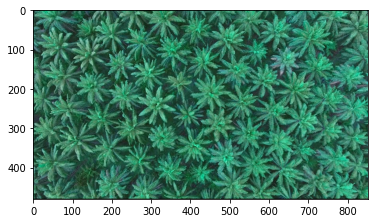

In [ ]:
# loading the image - let's take a look at it
image = cv2.imread(filename)
plt.imshow(image)

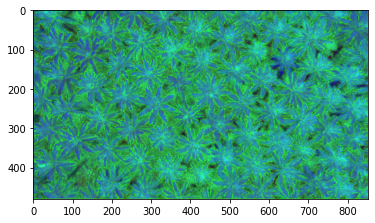

In [ ]:
# converting the image to hsv color channel - V channel will be useful for us..!!
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.imshow(hsv_image, cmap='hsv')

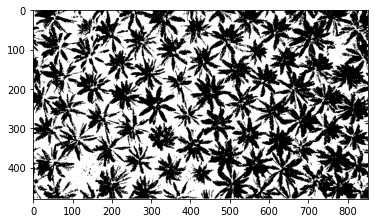

In [ ]:
# Thresholding the image in range 120 - 210 with OTSU
threshold, binary_image = cv2.threshold(hsv_image[:, :, 2], 120, 210, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(binary_image, cmap='binary')

Range was found by searching different values

OTSU performed better than other methods

The output image consists of pixel value 0 for the tress and 1 for the background

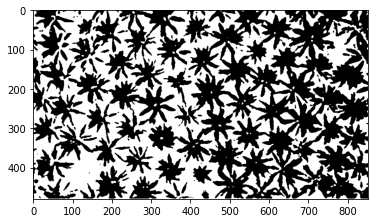

In [ ]:
# also let's do some filtering on the binary image to reduce noise by some factor
from skimage import data, io, filters
import numpy as np
image_denoised = filters.median(binary_image, selem=np.ones((5, 5)))
plt.imshow(image_denoised, cmap='binary')

Better than the previous plot..!!

In [ ]:
binary_image = image_denoised

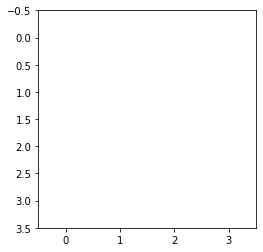

In [ ]:
# Let's make a kernal of 4x4 for mainpulating the image
kernel = np.ones((4, 4), dtype='uint8')
plt.imshow(kernel, cmap='binary')

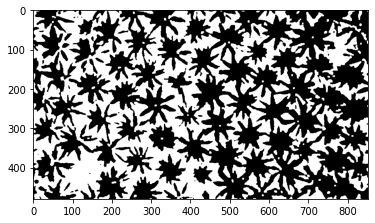

In [ ]:
# with the kernal we can do morphological closing to make the regions of interests - trees more dominant
morph_closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
plt.imshow(morph_closed_image, cmap='binary')

On comparing both the images we can see the regions with 0 value have clear edges now and all tmost all gaps are closed..!!

Some more accuracy can be obtained by playing with the kernal

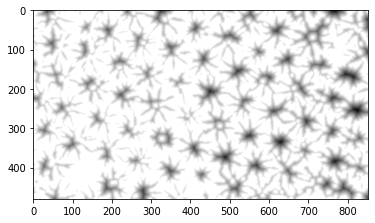

In [ ]:
# let's go for distance transfrom 
dist_transform_image = cv2.distanceTransform(morph_closed_image, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
plt.imshow(dist_transform_image, cmap='binary')

distance transfrom calculates the distance to the closest zero pixel for each pixel of the source image (from opencv documentation)



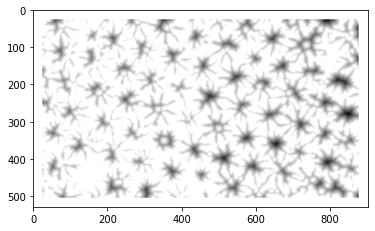

In [ ]:
# let's give some padding to the image so that further kernal operations will be easy..!

border_size = 25
dist_border = cv2.copyMakeBorder(dist_transform_image, border_size, border_size, border_size, border_size, 
                                cv2.BORDER_CONSTANT | cv2.BORDER_ISOLATED, 0)
plt.imshow(dist_border, cmap='binary')

Let's perform some template matching now. I have extracted image of a single tree choosen at random from the image..

It is saved as template.jpg

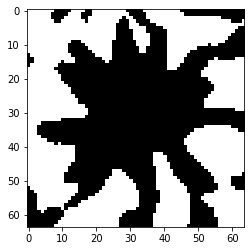

In [ ]:
gap = 8
template_file = cv2.imread(r'/content/template.jpg')
template_file = cv2.resize(template_file, (64, 64))
template_file = cv2.cvtColor(template_file, cv2.COLOR_BGR2HSV)
_, kernel2 = cv2.threshold(template_file[:, :, 2], 120, 210, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# median filtering the teamplate also..!!
image_denoised = filters.median(kernel2, selem=np.ones((5, 5)))
plt.imshow(image_denoised, cmap='binary')

Loaded the template file and converted it to HSV channel and did the same thresholding done to the original image to get the template that we can use for matching with the actual image.!!

Also, applied some denoising with median filter.. - Perfromed better than without filtering

In [ ]:
kernel2 = image_denoised

In [ ]:
# for the opencv to consider the kernal template we made it must be a binary image with 0 and 1
# let's convert the pixel values to 0's and 1's - ofcourse there are better methods :D

for i in range(len(kernel2)):
    for j in range(len(kernel2[i])):
        if kernel2[i][j] != 0:
            kernel2[i][j] = 1

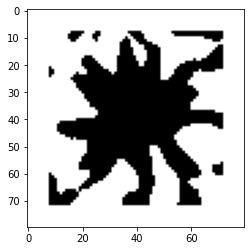

In [ ]:
# let's give some padding to our template - chosen after some trial and error.!!
kernel2 = cv2.copyMakeBorder(kernel2, gap, gap, gap, gap, cv2.BORDER_CONSTANT | cv2.BORDER_ISOLATED, 0)
plt.imshow(kernel2, cmap='binary')

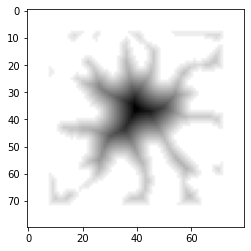

In [ ]:
# let's now apply distance transform on the template..!!
dist_trans_template = cv2.distanceTransform(kernel2, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
plt.imshow(dist_trans_template, cmap='binary')

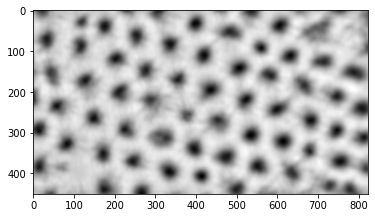

In [ ]:
# Finally, now we can try to match our template - not on the actual image but on the outputs of distance transforms
# simply because it is working better.!!
template_matched = cv2.matchTemplate(dist_border, dist_trans_template, cv2.TM_CCOEFF_NORMED)
plt.imshow(template_matched, cmap='binary')

From the above plot we can see that the template is getting matched somewhat good.. (Not Bad.!!)

Eventhough it is able to match in some cases it is failing to match in some cases..!! (Maybe I should try someother tree image as template.!)

In [ ]:
# Now let's threshold the template matched image..!!

mn, mx, _, _ = cv2.minMaxLoc(template_matched)
th, peaks = cv2.threshold(template_matched, 0.10, 0.60, cv2.THRESH_BINARY)

# let's go for the peak value in the template matched image..!
peaks8u = cv2.convertScaleAbs(peaks)

# find the coutnours in the peaks
contours, hierarchy = cv2.findContours(peaks8u, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
peaks8u = cv2.convertScaleAbs(peaks)

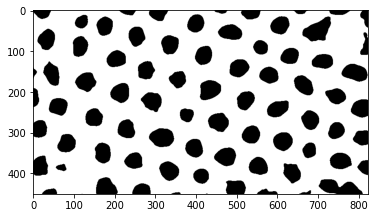

In [ ]:
plt.imshow(peaks8u, cmap='binary')

The operation was able to find countours corresponding to the tree somewhat correct..!

Yeah, there are many problems - Some countours are connected - May be some sharpening is needed.!!

In [ ]:
copy = cv2.imread(filename)

Number of trees :  72


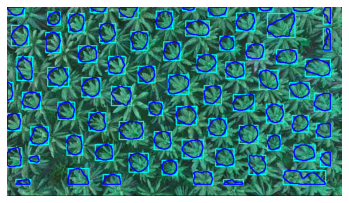

In [ ]:
# Now let's count the contouurs - the trees.!!

count = 0

for i in range(len(contours)):
    
    if cv2.contourArea(contours[i]) < 150:
        continue
        
    x, y, w, h = cv2.boundingRect(contours[i])    

    cv2.rectangle(copy, (x, y), (x+w, y+h), (0, 255, 255), 2)
    cv2.drawContours(copy, contours, i, (0, 0, 255), 2)
    
    count += 1

print('Number of trees : ', count)

# also let's see how the countours are selected by plotting countours on the actual image.!!
plt.axis('off')
plt.imshow(copy)

Eventhough some of the tress are getting considered in a good way, we can see some connected contours.!!!

These could be dealt with by some sharpening to the image.!!
